## import everything needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from matplotlib import rcParams
import sep
rcParams['figure.figsize'] = [10.,8.]

## get the image

In [2]:
image_file = './image.fits'
image_data = fits.getdata(image_file)

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


## Opening the FITS file

In [3]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: ./image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     337   (256, 256)   int16 (rescales to float32)   


ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


In [4]:
image_data = hdu_list[0].data

In [5]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(256, 256)


In [6]:
hdu_list.close()

In [7]:
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(256, 256)


ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


## get the background image

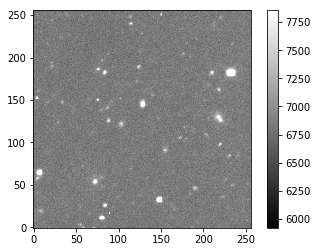

In [8]:
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('image_data.png')

In [9]:
# measure a spatially varying background on the image
bkg = sep.Background(image_data)

In [10]:
bkg = sep.Background(image_data, bw=64, bh=64, fw=3, fh=3)

## get a "global" mean and noise of the image background:

In [12]:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


## evaluate background as 2-d array, same size as original image

In [14]:
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

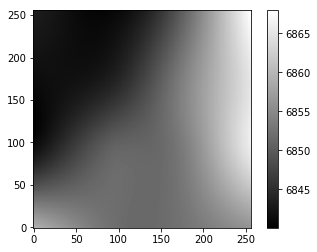

In [15]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('background.png')

In [16]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

## show the background noise

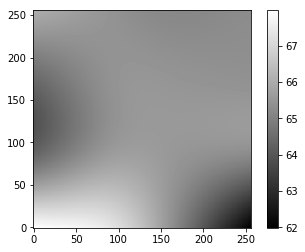

In [17]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('background_noise.png')

## background subtraction

In [21]:
data_sub = image_data - bkg

## Object detection

In [23]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [24]:
len(objects)

68

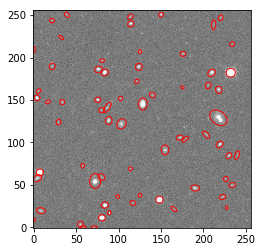

In [25]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    plt.savefig('subtracted_image.png')

## Aperture photometry

In [26]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [27]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))


object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138
